In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from tqdm import tqdm
import time
warnings.filterwarnings('ignore')

# Stratification method to reduce varience: 

One of the most common methods to increase our A/B test's power. Stratification allows to reduce varience of the data by reweighing each observation. 

# Experiment input:
The Analytics team of marketplace was asked to design the A/B test for the new feature. New feature was a new cart that uses purchased and added to cart products to offer an upsaling products. Example: a user added pair of leather shoes in the cart. The new fancy cart offers to buy Leather shoe cleaning kit in addition. The experiment will last for 2 weeks. Metric = The Average Order Value Per Client. A User "takes part" in experiment in case he was allocated in pilot group + made a purchase. The Analyst in our team provided the historical data of users who made a purchase over last 2 weeks


### Data description:
1. user_id:: unique user identifier
2. aov:: average order value of the user. Ex: user made first purchase 80 000 and second one 100 000, aov = 90 000
3. strat: user strat group that represents OS system. Strat == 1 if users uses IOS, Strat == 2 if users uses Android

In [2]:
df = pd.read_csv('data.csv')
df.head(5)

,user_id,aov,strat
0,1,389737.132241,1
1,2,338938.855906,1
2,3,401815.083048,1
3,4,471842.388513,1
4,5,331267.730022,1


In [3]:
# Let's look at our data
mu = df.aov.mean()
var = df.aov.var()
std = df.aov.std()
n_ios = df[df['strat'] == 1].shape[0]
n_android = df[df['strat'] == 2].shape[0]
print(f"""
Metric (Average Order Value) = {round(mu)}
Standard Deviation = {round(std)}
N of IOS users = {n_ios}
N of Android users = {n_android}
""")


Metric (Average Order Value) = 287475
Standard Deviation = 103449
N of IOS users = 35000
N of Android users = 25000



## We can estimate the Sample Size for T-test given Alpha Beta and MDE

In [4]:
alpha = 0.05
beta = 0.1
mde = 5000

def get_sample_size(mde, std, alpha, beta):
    numerator = 2 * (stats.norm.ppf(1-alpha/2) + stats.norm.ppf(1-beta))**2 * std**2
    denominator = mde**2
    return math.ceil(numerator / denominator)

sample_size = get_sample_size(mde, std, alpha, beta)
print(f'Sample Size = {sample_size}')

Sample Size = 8996


# Sample size is > 9000 observations, but...
Reminder: Our experiment "works" on users that not only were allocated in Pilot group, but made at least one purchase as well. But our testing feature for sure appears to users before we know if he is going to complete an order or not. Let's allocate "additional" users to our experiment taking into account the conversion rate from main page to purchase. In case we have conversion rate 10% we would need 89 960 users for the experiment. It is much more than our team can afford to allocate for the Experiment. Let's use the Stratification method in order to reduce Varience and Increase the Power of our experiment

### Stratification works the most in case there is a decent difference between stratification means and a little varience inside the Strat. Look at the Steps:
1. Determine the weights of each strat
2. Estimate the Strat means and Strat Varience

In [5]:
w1 = df[df['strat'] == 1].shape[0] / df.shape[0]
w2 = df[df['strat'] == 2].shape[0] / df.shape[0]

mean1 = df[df['strat'] == 1].aov.mean()
mean2 = df[df['strat'] == 2].aov.mean()

var1 = df[df['strat'] == 1].aov.var()
var2 = df[df['strat'] == 2].aov.var()

print(f"""
IOS: weight = {round(w1,2)}, mean = {round(mean1)}, std = {round(math.sqrt(var1))}
Android: weight = {round(w2,2)}, mean = {round(mean2)}, std = {round(math.sqrt(var2))}
""")


IOS: weight = 0.58, mean = 349851, std = 80208
Android: weight = 0.42, mean = 200148, std = 60036



In [6]:
# Let's estimate the Stratification Varience of our population:
def get_strat_mean(df):
    df = df.groupby('strat', as_index=False) \
        .agg({'aov':'mean'}) \
        .assign(weight = lambda x: np.where(x['strat'] == 1, w1, w2)) \
        .assign(weighted_var = lambda x: x['aov'] * x['weight'])
    return df.weighted_var.sum()

def get_strat_var(df): # Function calculates stratification varience
    df = df.groupby('strat', as_index=False) \
        .agg({'aov':'var'}) \
        .assign(weight = lambda x: np.where(x['strat'] == 1, w1, w2)) \
        .assign(weighted_var = lambda x: x['aov'] * x['weight'])
    return df.weighted_var.sum()

strat_var = get_strat_var(df)
print(f"""
Simple Varience = {round(var,2)}
Stratification Varience = {round(strat_var, 2)}
Difference = {round((var-strat_var) / var * 100,2)}%
""")


Simple Varience = 10701683256.55
Stratification Varience = 5254577285.44
Difference = 50.9%



# We did reduce our varience by 51%
Which means we are able to reduce our varience by 51% as well. Let's see:

In [7]:
s_sample_size = get_sample_size(mde, math.sqrt(strat_var), alpha, beta)
print(f"""
Sample size WITHOUT stratification = {sample_size}
Sample_size WITH stratification = {s_sample_size}
Difference = {sample_size-s_sample_size}
""")


Sample size WITHOUT stratification = 8996
Sample_size WITH stratification = 4417
Difference = 4579



# Validation of our design:
First let's see if the False Positive rate is on our design level 0.05

100%|████████████████████████████████████| 10000/10000 [00:59<00:00, 168.62it/s]


False Positive Rate = 0.0507


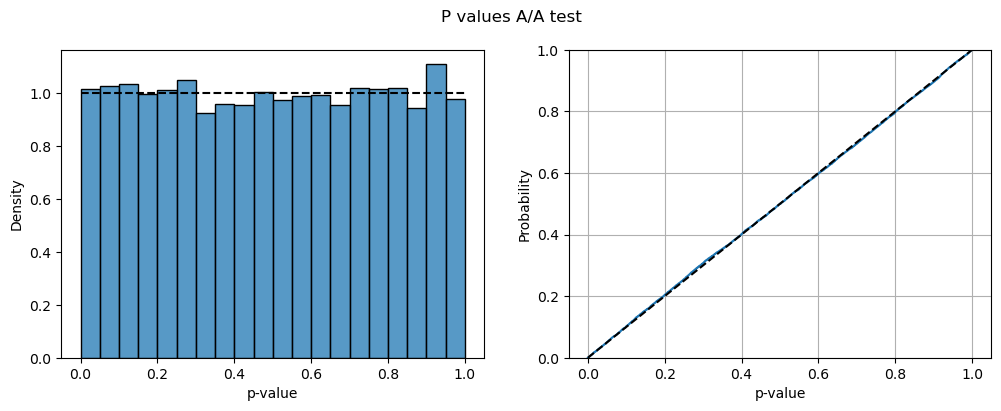

In [8]:
def get_pvalue(a_mean, b_mean, a_var, b_var): # Function calculates pvalue given stratification varience
    """
    a:: control group values
    b:: pilot group values
    strat_var:: stratification varience of the sample
    """
    delta = b_mean - a_mean
    se = math.sqrt(a_var/len(a) + b_var/len(b))
    t = delta/se
    pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
    return pvalue

def plot_pvalue_ecdf(pvalues, title=None): # Function creates P-value empirical distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

pvalues_aa = []
users_list = df.user_id.to_list()
for i in tqdm(range(10000)):
    np.random.shuffle(users_list)
    a_group, b_group = users_list[:s_sample_size], users_list[len(users_list) - s_sample_size:]
    a, b = df[df['user_id'].isin(a_group)], df[df['user_id'].isin(b_group)]
    a_var, b_var = get_strat_var(a), get_strat_var(b)
    a_mean, b_mean = get_strat_mean(a), get_strat_mean(b)
    pvalue = get_pvalue(a_mean, b_mean, a_var, b_var)
    pvalues_aa.append(pvalue)
    
plot_pvalue_ecdf(pvalues_aa, title = 'P values A/A test')
print(f'False Positive Rate = {(np.array(pvalues_aa) < alpha).mean()}')

100%|████████████████████████████████████| 10000/10000 [01:00<00:00, 164.14it/s]


Power = 0.9007


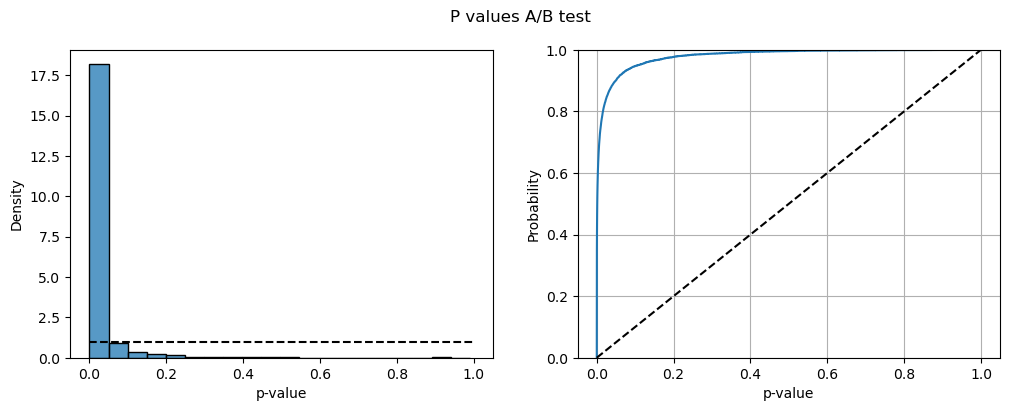

In [9]:
pvalues_ab = []
for i in tqdm(range(10000)):
    np.random.shuffle(users_list)
    a_group, b_group = users_list[:s_sample_size], users_list[len(users_list) - s_sample_size:]
    a, b = df[df['user_id'].isin(a_group)], df[df['user_id'].isin(b_group)]
    b['aov'] = b['aov'] + mde
    a_var, b_var = get_strat_var(a), get_strat_var(b)
    a_mean, b_mean = get_strat_mean(a), get_strat_mean(b)
    pvalue = get_pvalue(a_mean, b_mean, a_var, b_var)
    pvalues_ab.append(pvalue)
    
plot_pvalue_ecdf(pvalues_ab, title = 'P values A/B test')
print(f'Power = {(np.array(pvalues_ab) < alpha).mean()}')

# The experiment design is done
We are ready to run the A/B test on parameters: mde = 5000, std = 72488, alpha = 0.05, beta = 0.1